In [23]:
import xarray as xr
import pandas as pd
import numpy as np
import proplot as pplt
from pathlib import Path
import warnings

from AOSCMcoupling.convergence_checker import relative_error

In [24]:
class OASISPreprocessor:
    def __init__(
        self, origin: pd.Timestamp = None, time_shift: pd.Timedelta = pd.Timedelta(0)
    ):
        """Constructor.

        :param origin: start date (+ time) of the simulation
        :type origin: pd.Timestamp
        :param time_shift: time shift to apply for local time, default: 0
        :type time_shift: pd.Timedelta, optional
        """
        self.origin = origin
        self.time_shift = time_shift

    def preprocess(self, ds: xr.Dataset) -> xr.DataArray:
        """Preprocess function for use with `xr.open_mfdataset()`.

        :param ds: dataset as loaded from disk
        :type ds: xr.Dataset
        :return: preprocessed DataArray (only one variable!)
        :rtype: xr.DataArray
        """
        ds = ds.isel(ny=0, nx=0)

        source_file = Path(ds.encoding["source"])
        iteration = int(source_file.parent.name.split("_")[-1])
        ds = ds.expand_dims(
            iteration=[iteration],
        )
        time_data = np.array(ds.time.data, dtype="timedelta64[s]")
        ds = ds.assign_coords(time=ds.time - ds.time[0])

        if self.origin is not None:
            time_data = np.array(ds.time.data, dtype="timedelta64[s]")
            ds = ds.assign_coords(time=self.origin + time_data + self.time_shift)
        return ds


In [25]:
preprocessor = OASISPreprocessor(pd.Timestamp("2014-07-01"), pd.Timedelta(-7, "h"))

In [26]:
coupling_vars = [
    "A_TauX_oce",
    "A_TauY_oce",
    "A_TauX_ice",
    "A_TauY_ice",
    "A_Qs_mix",
    "A_Qns_mix",
    "A_Qs_ice",
    "A_Qns_ice",
    "A_Precip_liquid",
    "A_Precip_solid",
    "A_Evap_total",
    "A_Evap_ice",
    "A_dQns_dT",
    "O_SSTSST",
    "O_TepIce",
    "O_AlbIce",
    "OIceFrc",
    "OIceTck",
    "OSnwTck",
]

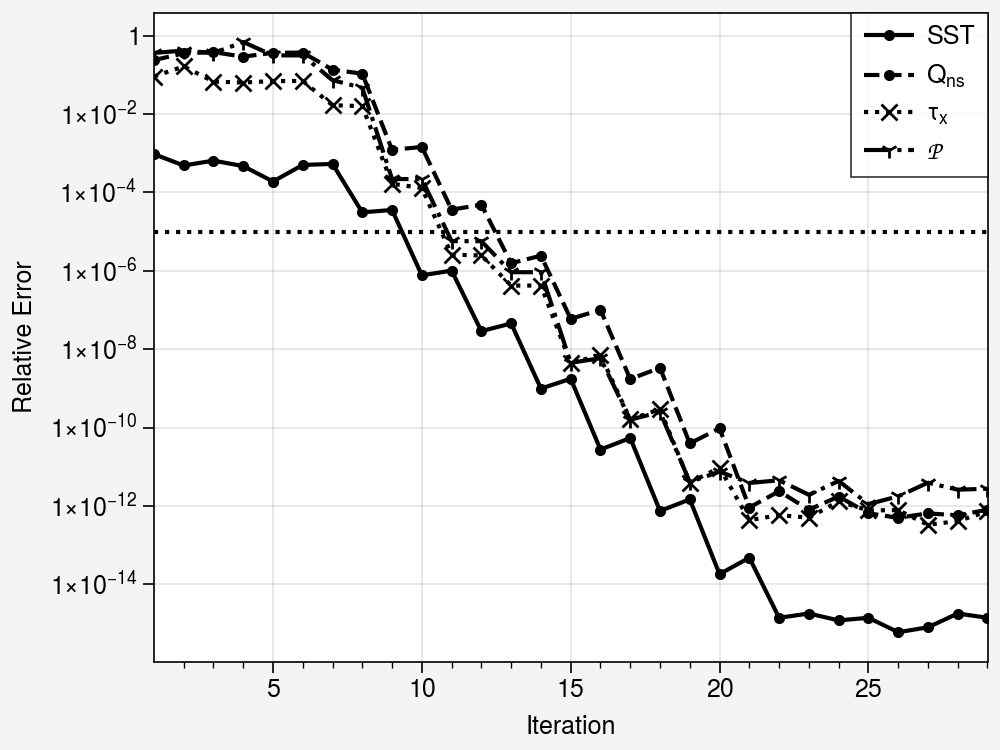

In [27]:
output_dir = Path("PAPA")
exp_id = "CEXS"
netcdf_files = [file for file in output_dir.glob(f"{exp_id}_*/*.nc")]
oasis_files = [file for file in netcdf_files if any(cv in file.name for cv in coupling_vars)]

plotting_dir = Path(f"plots/{exp_id}/convergence_plots")
plotting_dir.mkdir(parents=True, exist_ok=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ds = xr.open_mfdataset(oasis_files, preprocess=preprocessor.preprocess)
rel_errors_inf = relative_error(ds, ds.isel(iteration=-1), ds.isel(iteration=0), ord=np.inf)

fig, ax = pplt.subplots(width="40em", height="30em")
rel_errors_inf.sel(iteration=np.arange(1, 30)).O_SSTSST.plot(ax=ax, ls="-", marker=".", label="SST", color="k")
rel_errors_inf.sel(iteration=np.arange(1, 30)).A_Qns_mix.plot(ax=ax, ls="--", marker=".", label=r"$Q_\mathrm{ns}$", color="k")
rel_errors_inf.sel(iteration=np.arange(1, 30)).A_TauX_oce.plot(ax=ax, ls=":", marker="x", label=r"$\tau_x$", color="k")
rel_errors_inf.sel(iteration=np.arange(1, 30)).A_Precip_liquid.plot(ax=ax, ls="-.", marker="1", label=r"$\mathcal{P}$", color="k")

ax.hlines(1e-5, 1, 29, ls=":", color="k")

ax.format(
        yscale="log",
        yformatter="sci",
        ylabel="Relative Error",
        xlabel="Iteration",
    )
ax.legend(ncols=1)
fig.savefig(plotting_dir / "swr_convergence_combined.pdf")
